In [1]:
import pickle


def incr_value(dct, key, val):
    if key in dct:
        dct[key] += val
    else:
        dct[key] = val


approved_relations = set([
    'borrowed_from',
    'derived_from',
    'inherited_from',
    'abbreviation_of',
    'clipping_of',
    'compound_of',
    'calque_of',
    'blend_of',
    'unadapted_borrowing_from',
    'learned_borrowing_from',
    'orthographic_borrowing_from',
    'named_after',
    'semantic_loan_of',
    'phono-semantic_matching_of',
    'initialism_of',
])

data = []
header = None
n_colums = None

cnt_german = dict()
cnt_latin = dict()

# taken from https://github.com/droher/etymology-db
for line in open("etymology.csv"):
    
    if header is None:
        header = line.split(',')
        n_columns = len(header)
        continue

    tokens = line.split(',')
    if len(tokens) < n_columns:
        continue

    lang1 = tokens[1]    
    term1 = tokens[2]
    reltype = tokens[3]
    lang2 = tokens[5]
    term2 = tokens[6]
    
    if lang1 != 'English':
        continue    
    if reltype not in approved_relations:
        continue
    if term1 == '' or lang2 == '' or term2 == '':
        continue

    if ("French" in lang2) or ("Latin" in lang2):
        incr_value(cnt_latin, term1, 1)
    if ("German" in lang2):
        incr_value(cnt_german, term1, 1)


with open("counts.pickle", "wb") as counts_file:
    pickle.dump((cnt_latin, cnt_german), counts_file)

In [2]:
import pickle
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


dict_latin, dict_german = pickle.load(open("counts.pickle", "rb"))


def calc_latin_german_word(word):
    cnt_latin, cnt_german = dict_latin.get(word, 0), dict_german.get(word, 0)
    total = cnt_latin + cnt_german
    if total == 0:
        return 0., 0.
    else:
        return (cnt_latin / total), (cnt_german / total)


# taken from http://agailloty.rbind.io/project/nlp_clean-text/
def clean_text(text):
    """
    This function takes as input a text on which several
    NLTK algorithms will be applied in order to preprocess it
    """
    if type(text) == str:
        tokens = word_tokenize(text)
    elif type(text) == list:
        tokens = text
    else:
        raise ValueError("Provide string or list of words")
    # Remove the punctuations
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
    tokens = [word for word in tokens if not word in stopwords.words("english")]
    # Lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    return tokens


def calc_latin_german(text, normalize = True):
    text = clean_text(text)
    sum_german, sum_latin = 0., 0.
    for word in text:
        upd_latin, upd_german = calc_latin_german_word(word)
        sum_latin += upd_latin
        sum_german += upd_german
    if normalize:
        total = sum_german + sum_latin
        if total < 1e-5:
            raise ValueError("Text is not in English or too small")
        return sum_latin / total, sum_german / total
    else:
        return sum_latin, sum_german


[nltk_data] Downloading package punkt to /home/alexey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alexey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alexey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alexey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from nltk.corpus import brown

results = dict()

for category in brown.categories():
    latin, german = calc_latin_german(list(brown.words(categories=category)))
    results["br_" + category] = latin
    
    print(category, 100 * latin, "% latin,", 100 * german, "% german")

adventure 36.62762336105941 % latin, 63.37237663894059 % german
belles_lettres 60.40481380887696 % latin, 39.59518619112304 % german
editorial 60.987120371855916 % latin, 39.01287962814408 % german
fiction 39.44392520199663 % latin, 60.55607479800338 % german
government 75.26326683743441 % latin, 24.736733162565585 % german
hobbies 58.30643219187556 % latin, 41.693567808124456 % german
humor 49.14102507504853 % latin, 50.858974924951475 % german
learned 71.69940650228442 % latin, 28.30059349771558 % german
lore 57.44836158494682 % latin, 42.55163841505317 % german
mystery 39.48031402171861 % latin, 60.5196859782814 % german
news 60.151379449067264 % latin, 39.848620550932736 % german
religion 59.80568820434642 % latin, 40.19431179565358 % german
reviews 58.14681932451644 % latin, 41.853180675483564 % german
romance 37.34038353466812 % latin, 62.659616465331894 % german
science_fiction 48.44093458755114 % latin, 51.55906541244888 % german


In [4]:
from nltk.corpus import webtext

latin, german = calc_latin_german(list(webtext.words()))
results['webtext'] = latin
print(latin, german)

0.4558846895183944 0.5441153104816057


In [5]:
from nltk.corpus import inaugural
latin, german = calc_latin_german(inaugural.raw())
results['inaugural'] = latin

<BarContainer object of 17 artists>

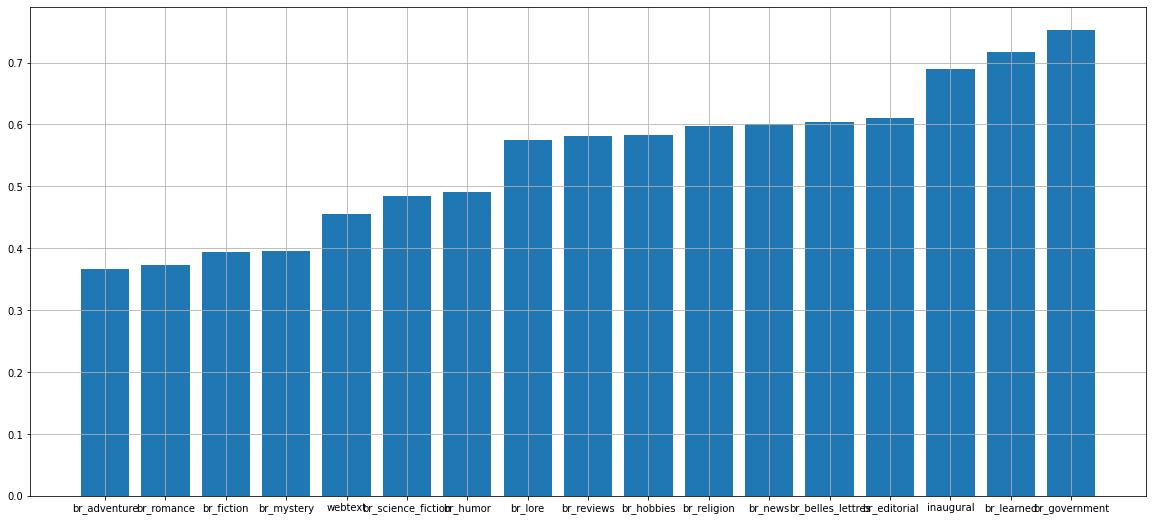

In [6]:
import matplotlib.pyplot as plt

pairs = sorted([(value, key) for key, value in results.items()])
y = [i[0] for i in pairs]
x = [i[1] for i in pairs]

plt.figure(figsize=(20, 9))
plt.grid(True)
plt.bar(x, y)